## MPF training

Below is my test code to use MPF training for a fully-connected Boltzmann machine with 16 units with no GPU consideration.

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

import os
import timeit

%matplotlib inline

In [2]:
def load_data(dataset = '32-50K.npy', borrow = True):
    """
    Loads the dataset.
    """

    data = np.load(dataset)
    dataset = theano.shared(np.asarray(data, dtype = theano.config.floatX), borrow = borrow)

    return dataset

In [3]:
class mpf(object):
    """
    Minimum probability flow
    """
    
    def __init__(self, input = None, n = 16, temperature = 1,  W = None, b = None):
        
        self.n = n
        self.temperature = temperature
        U = np.random.rand(self.n, self.n)
        R = 0.5 * (U + U.T)
        np.fill_diagonal(R, 0)

        if not W:
            initial_W = np.asarray(R, dtype = theano.config.floatX)
            W = theano.shared(initial_W, name = 'W', borrow = True)

        if not b:
            initial_b = np.asarray(np.random.rand(n), dtype = theano.config.floatX)
            b = theano.shared(initial_b, name = 'b', borrow = True)


        self.W = W
        self.b = b
        
        if input is None:
            self.x = T.dmatrix(name = 'input')
        else:
            self.x = input

        self.params = [self.W, self.b]
    
    
    def cost(self, lr = 1e-2, epsilon = 1):
        """
        Returns the cost of vanilla SGD. 
        The update rule enforces that the W matrix at each timestep is symmetric.
        """
         
        print (51 * '=')
        print (24 * '#' + 'MPF' + 24 * '#')
        print (51 * '=')
        print ('Input size: {0}'.format(self.n))
        print ('Learning temperature: {0}'.format(self.temperature))
        print ('Learning rate: {0}'.format(lr))
        
        cost = epsilon * T.mean(T.exp((0.5 - self.x) * (T.dot(self.x, self.W) + self.b) / self.temperature)) 
        Wgrad = T.grad(cost, self.W)
        bgrad = T.grad(cost, self.b)
           
        Wupdate = T.fill_diagonal(0.5 * ((self.W - lr * Wgrad) + (self.W - lr * Wgrad).T), 0)
        updates = [(self.W, Wupdate), (self.b, self.b - lr * bgrad )]

        return cost, updates

In [4]:
def trainmpf(units = 32, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy'):
    """
    Trains parameters using MPF.
    """
    
    index = T.lscalar()
    x = T.matrix('x')
    flow = mpf(input = x, n = units, temperature = temperature)
    
    cost, updates = flow.cost(lr = lr, epsilon = epsilon)
    
    dataset = load_data(sample)
    n_dataset_batches = dataset.get_value(borrow = True).shape[0] // batchsize

    print ('Sample used: {0}'.format(sample))
    print ('=' * 51)
    
    mpf_cost = theano.function(inputs = [index], outputs = cost, updates = updates, \
                                givens = {x: dataset[index * batchsize: (index + 1) * batchsize]})
    
    start_time = timeit.default_timer()
    
    best_mse = np.inf
    best_W = [None, np.inf]
    best_b = [None, np.inf]
    
    for epoch in range(n_epochs):
        c = []
        current_time = timeit.default_timer()
        for batch_index in range(n_dataset_batches):
            c.append(mpf_cost(batch_index))
        
        W_learnt = flow.W.get_value(borrow = True)
        b_learnt = flow.b.get_value(borrow = True)
        
        W = np.load(sample[0:2] + '-' + 'W' + '.npy')
        b = np.load(sample[0:2] + '-' + 'b' + '.npy')
        
        mseW = np.linalg.norm(W - W_learnt)/ (units**2 - units)/2
        mseb = np.linalg.norm(b - b_learnt)/ units
#         mse = (mseW * mseb)/(mseW + mseb)
        mse = mseW + mseb
        
        if mse < best_mse:
            best_mse = mse
            best_W[0] = flow.W.get_value(borrow = True)
            best_W[1] = mseW
            best_b[0] = flow.b.get_value(borrow = True)
            best_b[1] = mseb
            best_cost = np.mean(c, dtype='float64')
            best_epoch = epoch
        
        if epoch%validate_every == 0:
            print ('Training epoch %d/%d, Cost: %f mseW: %.5f, mseb: %.5f, mse: %.5f Time Elasped: %.2f '\
                 % (epoch, n_epochs, np.mean(c, dtype='float64'), \
                 mseW, mseb, mse, (current_time - start_time)/60) )
    
    end_time = timeit.default_timer()

    training_time = end_time - start_time
    
    fig, ax = plt.subplots(2, figsize=(20,10))
    fig.tight_layout()

    ax[0].plot(W.reshape(-1,1)[0:100], 'b')
    ax[0].plot(W_learnt.reshape(-1,1)[0:100], 'r')
    ax[0].set_title('W')
    ax[0].legend(['W', 'Learnt W'])
    ax[1].plot(b.reshape(-1,1), 'b')
    ax[1].plot(b_learnt.reshape(-1,1),'r')
    ax[1].set_title('b')
    ax[1].legend(['b', 'Learnt b'])

    
    print ('The training took %.2f minutes' % (training_time/60.))
    print ('#' * 22 + 'Results' + '#' * 22)
    print ('=' * 51)
    print ('Best mse: {0}'.format(mse))
    print ('Best W mse: {0}'.format(mseW))
    print ('Best b mse: {0}'.format(mseb))
    print ('=' * 51)

########################MPF########################
Input size: 16
Learning temperature: 1
Learning rate: 0.01
Sample used: 16-50K.npy


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '7448' (I am process '9656')


Training epoch 0/1000, Cost: 1.158754 mseW: 0.02274, mseb: 0.20364, mse: 0.22638 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.660364 mseW: 0.00484, mseb: 0.10528, mse: 0.11012 Time Elasped: 0.35 
Training epoch 200/1000, Cost: 0.659625 mseW: 0.00278, mseb: 0.06614, mse: 0.06891 Time Elasped: 0.68 
Training epoch 300/1000, Cost: 0.659487 mseW: 0.00218, mseb: 0.04756, mse: 0.04975 Time Elasped: 1.01 
Training epoch 400/1000, Cost: 0.659447 mseW: 0.00201, mseb: 0.03864, mse: 0.04065 Time Elasped: 1.34 
Training epoch 500/1000, Cost: 0.659431 mseW: 0.00197, mseb: 0.03440, mse: 0.03637 Time Elasped: 1.68 
Training epoch 600/1000, Cost: 0.659425 mseW: 0.00197, mseb: 0.03243, mse: 0.03440 Time Elasped: 2.01 
Training epoch 700/1000, Cost: 0.659422 mseW: 0.00197, mseb: 0.03154, mse: 0.03351 Time Elasped: 2.35 
Training epoch 800/1000, Cost: 0.659420 mseW: 0.00198, mseb: 0.03116, mse: 0.03314 Time Elasped: 2.69 
Training epoch 900/1000, Cost: 0.659420 mseW: 0.00199, mseb: 0.03104, mse: 

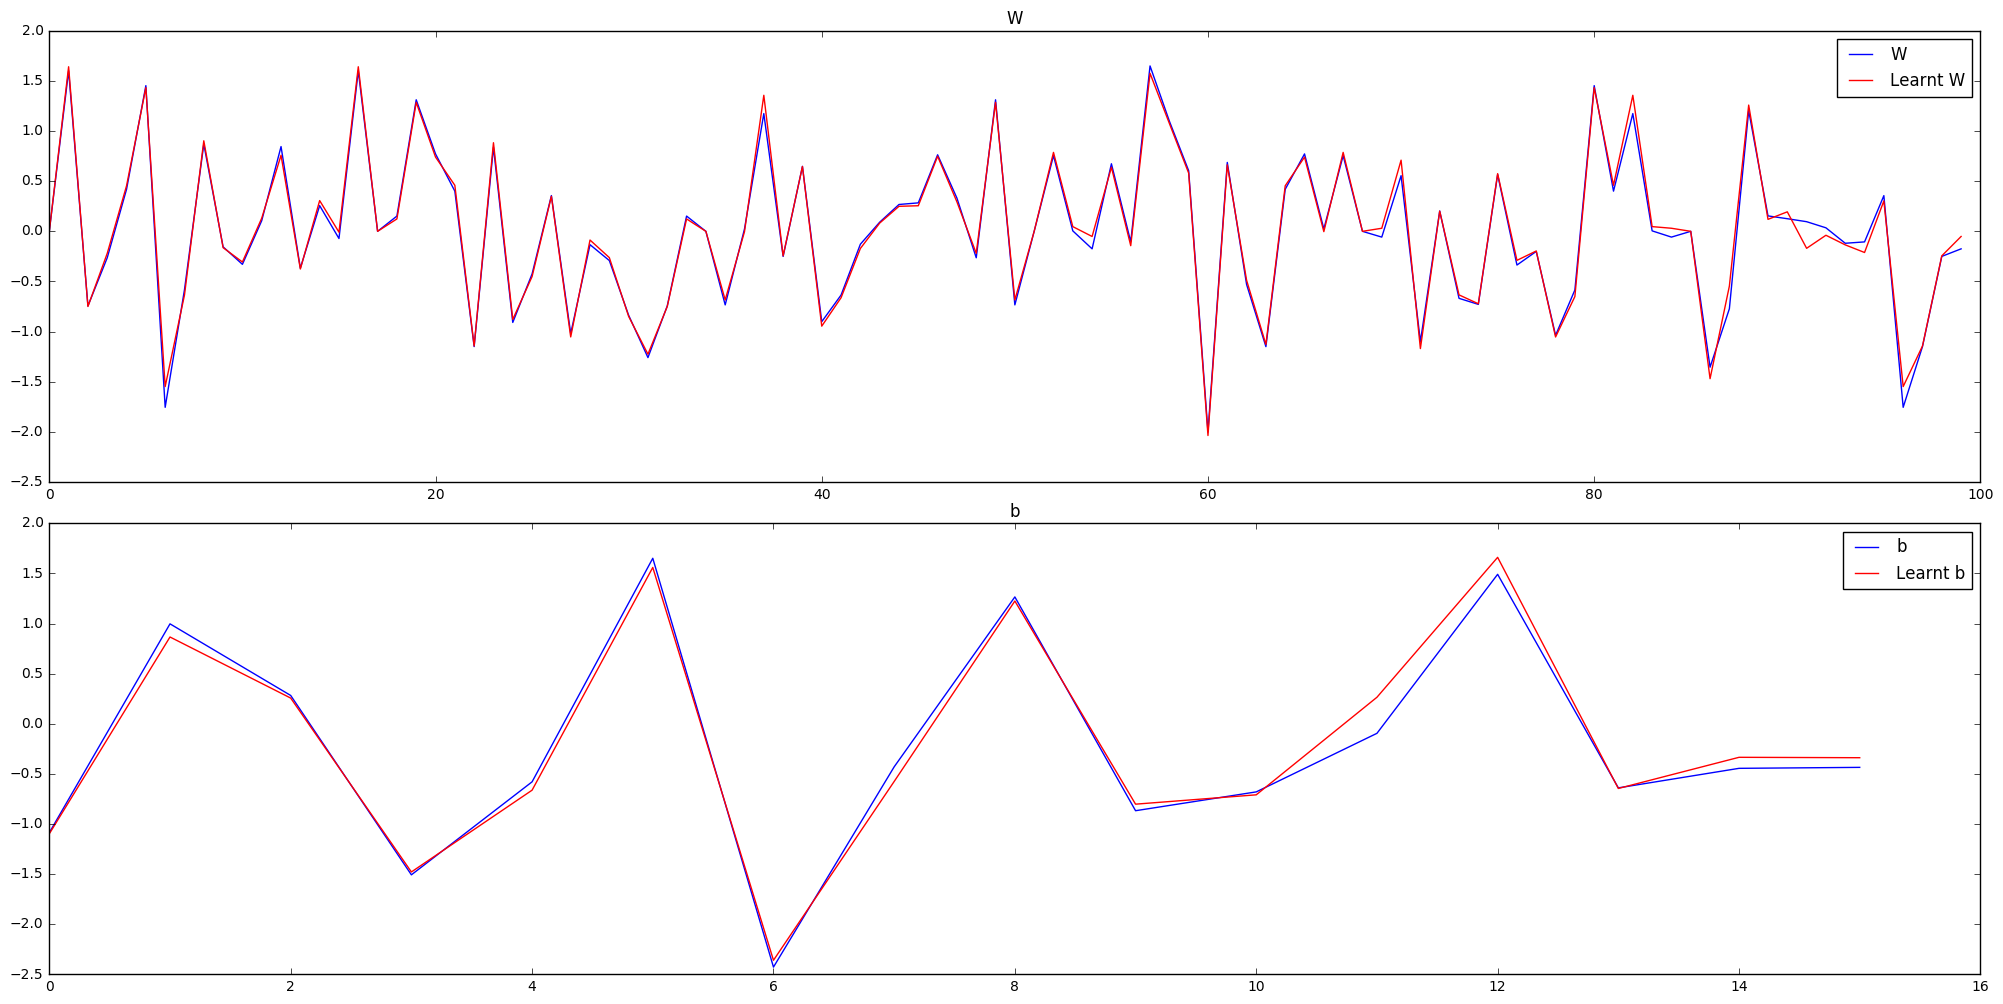

In [5]:
trainmpf(units = 16, lr = 1e-2, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')

########################MPF########################
Input size: 16
Learning temperature: 1
Learning rate: 0.001
Sample used: 16-50K.npy
Training epoch 0/1000, Cost: 3.127711 mseW: 0.02662, mseb: 0.27265, mse: 0.29927 Time Elasped: 0.00 
Training epoch 100/1000, Cost: 0.688566 mseW: 0.01638, mseb: 0.16776, mse: 0.18414 Time Elasped: 0.40 
Training epoch 200/1000, Cost: 0.672629 mseW: 0.01273, mseb: 0.15607, mse: 0.16880 Time Elasped: 0.77 
Training epoch 300/1000, Cost: 0.666798 mseW: 0.01050, mseb: 0.14608, mse: 0.15658 Time Elasped: 1.12 
Training epoch 400/1000, Cost: 0.664087 mseW: 0.00897, mseb: 0.13720, mse: 0.14617 Time Elasped: 1.49 
Training epoch 500/1000, Cost: 0.662622 mseW: 0.00783, mseb: 0.12925, mse: 0.13708 Time Elasped: 1.83 
Training epoch 600/1000, Cost: 0.661745 mseW: 0.00695, mseb: 0.12209, mse: 0.12904 Time Elasped: 2.17 
Training epoch 700/1000, Cost: 0.661178 mseW: 0.00625, mseb: 0.11559, mse: 0.12184 Time Elasped: 2.51 
Training epoch 800/1000, Cost: 0.660789 ms

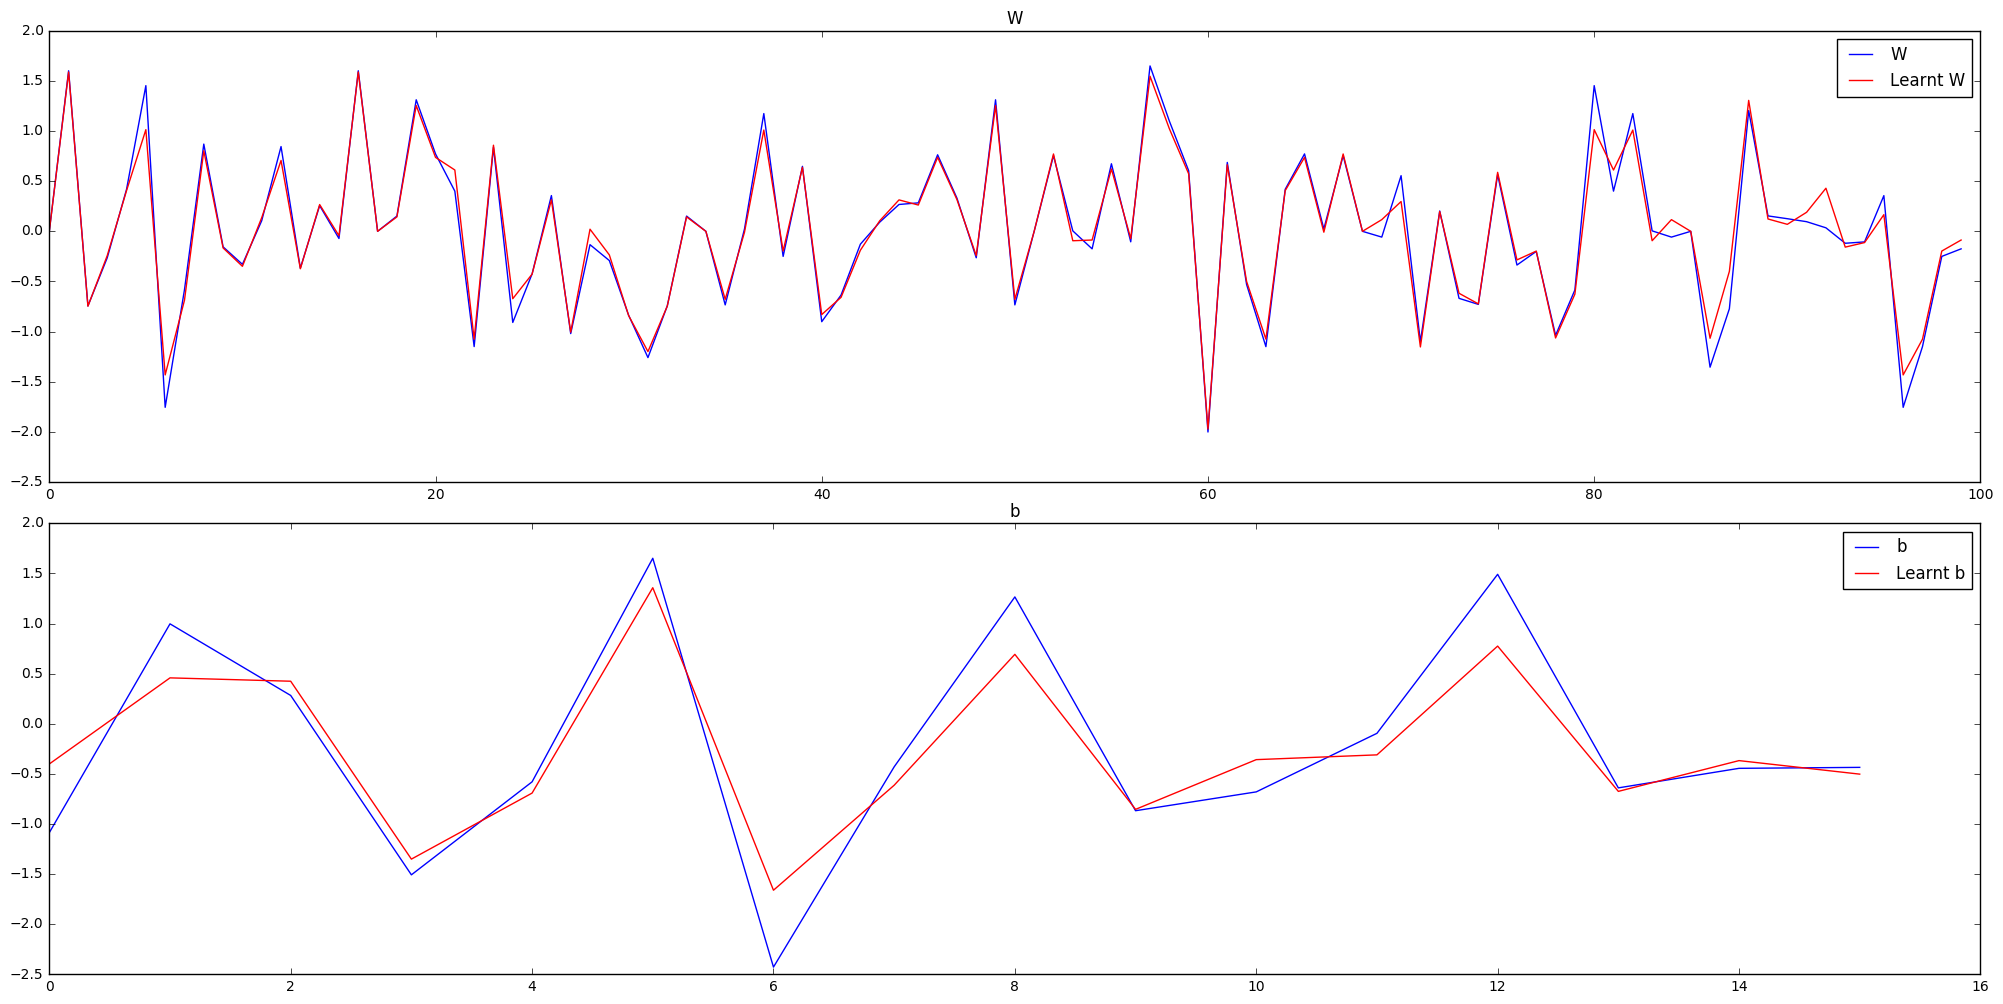

In [6]:
trainmpf(units = 16, lr = 1e-3, epsilon = 1, n_epochs = 1000,
             batchsize = 16, temperature = 1, validate_every = 100, sample = '16-50K.npy')